In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)


In [ ]:
df = pd.read_csv(
    "../data/MachineLearningRating_v3.txt",  
    sep="|",
    low_memory=False
)

print("✅ Data loaded successfully")


✅ Data loaded successfully


In [3]:
print("=== BASIC INFO ===")
print(f"Shape: {df.shape}")

print("\nColumns:")
print(df.columns.tolist())

print("\nData types:")
print(df.dtypes)

print("\nMissing values (top 20):")
print(df.isnull().sum().sort_values(ascending=False).head(20))


=== BASIC INFO ===
Shape: (1000098, 52)

Columns:
['UnderwrittenCoverID', 'PolicyID', 'TransactionMonth', 'IsVATRegistered', 'Citizenship', 'LegalType', 'Title', 'Language', 'Bank', 'AccountType', 'MaritalStatus', 'Gender', 'Country', 'Province', 'PostalCode', 'MainCrestaZone', 'SubCrestaZone', 'ItemType', 'mmcode', 'VehicleType', 'RegistrationYear', 'make', 'Model', 'Cylinders', 'cubiccapacity', 'kilowatts', 'bodytype', 'NumberOfDoors', 'VehicleIntroDate', 'CustomValueEstimate', 'AlarmImmobiliser', 'TrackingDevice', 'CapitalOutstanding', 'NewVehicle', 'WrittenOff', 'Rebuilt', 'Converted', 'CrossBorder', 'NumberOfVehiclesInFleet', 'SumInsured', 'TermFrequency', 'CalculatedPremiumPerTerm', 'ExcessSelected', 'CoverCategory', 'CoverType', 'CoverGroup', 'Section', 'Product', 'StatutoryClass', 'StatutoryRiskType', 'TotalPremium', 'TotalClaims']

Data types:
UnderwrittenCoverID      int64
PolicyID                 int64
TransactionMonth        object
IsVATRegistered           bool
Citizenship

In [4]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000098 entries, 0 to 1000097
Data columns (total 52 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   UnderwrittenCoverID       1000098 non-null  int64  
 1   PolicyID                  1000098 non-null  int64  
 2   TransactionMonth          1000098 non-null  object 
 3   IsVATRegistered           1000098 non-null  bool   
 4   Citizenship               1000098 non-null  object 
 5   LegalType                 1000098 non-null  object 
 6   Title                     1000098 non-null  object 
 7   Language                  1000098 non-null  object 
 8   Bank                      854137 non-null   object 
 9   AccountType               959866 non-null   object 
 10  MaritalStatus             991839 non-null   object 
 11  Gender                    990562 non-null   object 
 12  Country                   1000098 non-null  object 
 13  Province                  1

In [7]:
# Robust date parsing

# TransactionMonth usually YYYY-MM
df['TransactionMonth'] = pd.to_datetime(
    df['TransactionMonth'],
    format='mixed',   # handles multiple formats
    errors='coerce'
)

# VehicleIntroDate has inconsistent formats
df['VehicleIntroDate'] = pd.to_datetime(
    df['VehicleIntroDate'],
    format='mixed',
    errors='coerce'
)


# Numeric column conversion
numeric_cols = [
    'TotalPremium',
    'TotalClaims',
    'SumInsured',
    'CalculatedPremiumPerTerm',
    'CustomValueEstimate'
]

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')



In [8]:
print("Missing TransactionMonth:", df['TransactionMonth'].isna().mean() * 100, "%")
print("Missing VehicleIntroDate:", df['VehicleIntroDate'].isna().mean() * 100, "%")

Missing TransactionMonth: 0.0 %
Missing VehicleIntroDate: 0.05519459093008885 %


In [10]:
#distribution
#mean
#min/max
#presence of outliers
df[numeric_cols].describe()

,TotalPremium,TotalClaims,SumInsured,CalculatedPremiumPerTerm,CustomValueEstimate
count,1.000098e+06,1.000098e+06,1.000098e+06,1.000098e+06,2.204560e+05
mean,6.190550e+01,6.486119e+01,6.041727e+05,1.178757e+02,2.255311e+05
std,2.302845e+02,2.384075e+03,1.508332e+06,3.997017e+02,5.645157e+05
min,-7.825768e+02,-1.200241e+04,1.000000e-02,0.000000e+00,2.000000e+04
25%,0.000000e+00,0.000000e+00,5.000000e+03,3.224800e+00,1.350000e+05
50%,2.178333e+00,0.000000e+00,7.500000e+03,8.436900e+00,2.200000e+05
75%,2.192982e+01,0.000000e+00,2.500000e+05,9.000000e+01,2.800000e+05
max,6.528260e+04,3.930921e+05,1.263620e+07,7.442217e+04,2.655000e+07


In [11]:
missing_percent = (df.isnull().mean() * 100).sort_values(ascending=False)

missing_percent[missing_percent > 0].head(15)


NumberOfVehiclesInFleet    100.000000
CrossBorder                 99.930207
CustomValueEstimate         77.956560
Rebuilt                     64.183810
Converted                   64.183810
WrittenOff                  64.183810
NewVehicle                  15.327998
Bank                        14.594670
AccountType                  4.022806
Gender                       0.953507
MaritalStatus                0.825819
VehicleType                  0.055195
make                         0.055195
mmcode                       0.055195
Model                        0.055195
dtype: float64

In [14]:
# Safe loss ratio calculation
df['loss_ratio'] = np.where(
    df['TotalPremium'] > 0,
    df['TotalClaims'] / df['TotalPremium'],
    np.nan
)

# Remove infinite values (future-proof)
df['loss_ratio'] = df['loss_ratio'].replace([np.inf, -np.inf], np.nan)

df['loss_ratio'].describe()

count    618176.000000
mean          0.350048
std           9.288639
min         -18.700122
25%           0.000000
50%           0.000000
75%           0.000000
max        2553.600000
Name: loss_ratio, dtype: float64

In [15]:
df['loss_ratio_capped'] = df['loss_ratio'].clip(lower=0, upper=5)

df['loss_ratio_capped'].describe()

count    618176.000000
mean          0.020901
std           0.321503
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           5.000000
Name: loss_ratio_capped, dtype: float64

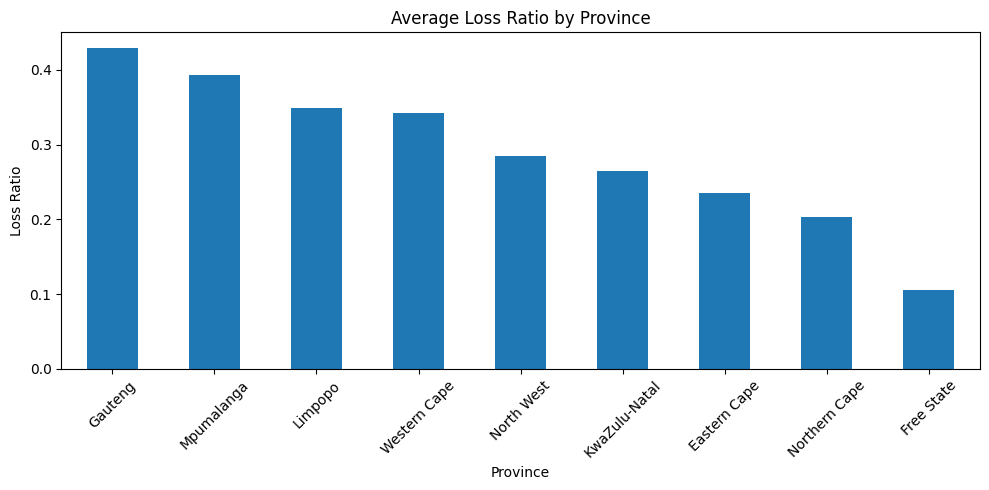

In [17]:
loss_by_province = (
    df.groupby('Province')['loss_ratio']
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(10,5))
loss_by_province.plot(kind='bar')
plt.title("Average Loss Ratio by Province")
plt.ylabel("Loss Ratio")
plt.xlabel("Province")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../images/loss_ratio_by_province.png", dpi=150)
plt.show()

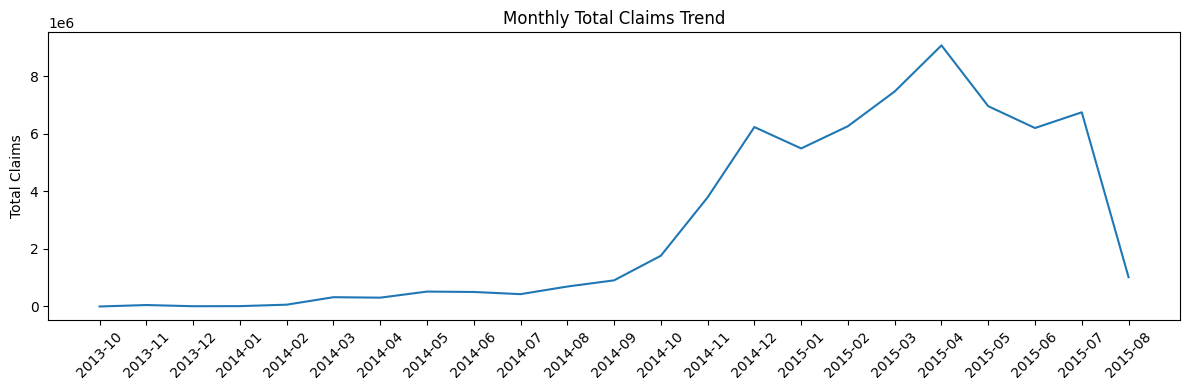

In [18]:
monthly_claims = (
    df.groupby(df['TransactionMonth'].dt.to_period('M'))['TotalClaims']
    .sum()
)

monthly_claims.index = monthly_claims.index.astype(str)

plt.figure(figsize=(12,4))
plt.plot(monthly_claims.index, monthly_claims.values)
plt.xticks(rotation=45)
plt.title("Monthly Total Claims Trend")
plt.ylabel("Total Claims")
plt.tight_layout()
plt.savefig("../images/monthly_total_claims.png", dpi=150)
plt.show()


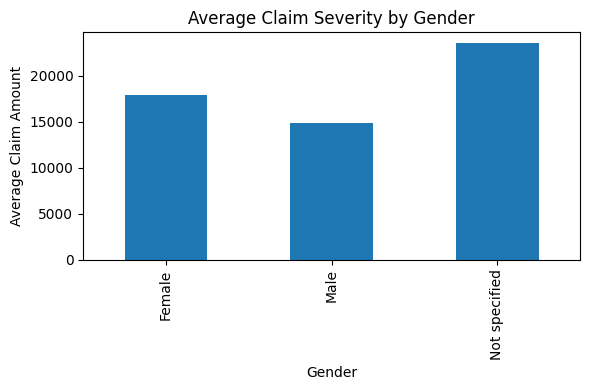

In [19]:
severity_by_gender = (
    df[df['TotalClaims'] > 0]
    .groupby('Gender')['TotalClaims']
    .mean()
)

plt.figure(figsize=(6,4))
severity_by_gender.plot(kind='bar')
plt.title("Average Claim Severity by Gender")
plt.ylabel("Average Claim Amount")
plt.tight_layout()
plt.savefig("../images/claim_severity_by_gender.png", dpi=150)
plt.show()


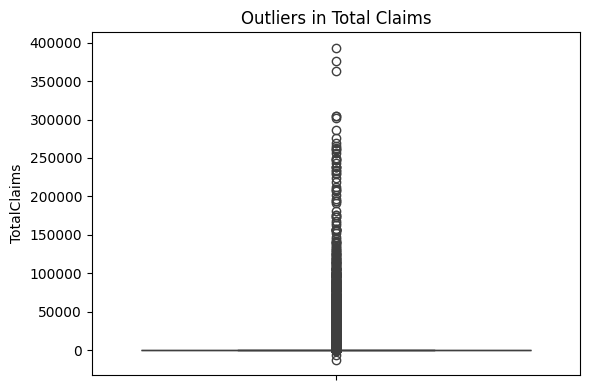

In [20]:
plt.figure(figsize=(6,4))
sns.boxplot(y=df['TotalClaims'])
plt.title("Outliers in Total Claims")
plt.tight_layout()
plt.show()

In [21]:
df['VehicleType'].value_counts().head(10)
df['CoverType'].value_counts().head(10)

CoverType
Own Damage                                 104183
Passenger Liability                        104158
Windscreen                                 103763
Third Party                                102825
Keys and Alarms                            102428
Signage and Vehicle Wraps                  102416
Emergency Charges                          102416
Cleaning and Removal of Accident Debris    102414
Income Protector                            64813
Basic Excess Waiver                         57769
Name: count, dtype: int64

In [22]:
df.to_csv("../data/eda_clean_sample.csv", index=False)